In [1]:
import os, sys, time
import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Get the test videos

In [2]:
test_dir = "/kaggle/input/deepfake-detection-challenge/test_videos/"

test_videos = sorted([x for x in os.listdir(test_dir) if x[-4:] == ".mp4"])
len(test_videos)

400

## Create helpers

In [3]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.3.0
CUDA version: 10.0.130
cuDNN version: 7603


In [4]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [5]:
import sys
sys.path.insert(0, "/kaggle/input/blazeface-pytorch")

from blazeface import BlazeFace
facedet = BlazeFace().to(gpu)
facedet.load_weights("/kaggle/input/blazeface-pytorch/blazeface.pth")
facedet.load_anchors("/kaggle/input/blazeface-pytorch/anchors.npy")
_ = facedet.train(False)

In [6]:
def read_frames(path):
    v_cap = cv2.VideoCapture(path)
    v_int = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if v_int <= 0: return None

    frame_idxs = np.linspace(0, v_int - 1, frames_per_vid, endpoint=True, dtype=np.int)

    result = []
    for i in range(v_int):
        ret = v_cap.grab()
        if ret is None:
            continue
            
        if i in frame_idxs:
            ret, frame = v_cap.retrieve()
            if ret is None or frame is None:
                continue
    
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result.append(frame)
            
    v_cap.release()
    return np.array(result)

In [7]:
class FaceExtractor:
    
    def __init__(self, video_read_fn, facedet):

        self.video_read_fn = video_read_fn
        self.facedet = facedet
    
    def process_video(self, video_path):
        """Convenience method for doing face extraction on a single video."""
 
        result = []
    
        target_size = self.facedet.input_size
        
        # 1 - get frames
        frames = self.video_read_fn(video_path)
        # Error? Then skip this video.
        if frames is None: return result
            
            
        # 2 - split the frames into several tiles. Resize the tiles to 128x128.
        tiles, resize_info = self._tile_frames(frames, target_size)
        
        
        # 3 - Run the face detector. The result is a list of PyTorch tensors, 
        # one for each image in the batch.
        detections = self.facedet.predict_on_batch(tiles, apply_nms=False)
        
        # 3 - convert the detections from 128x128 back to the original frame size.
        detections = self._resize_detections(detections, target_size, resize_info)
        
        
        # 4 - Because we have several tiles for each frame, combine the predictions
        # from these tiles. The result is a list of PyTorch tensors, but now one
        # for each frame (rather than each tile).
        num_frames = frames.shape[0]
        frame_size = (frames.shape[2], frames.shape[1])
        detections = self._untile_detections(num_frames, frame_size, detections)
        
         
        # 5 - The same face may have been detected in multiple tiles, so filter out
        # overlapping detections. This is done separately for each frame.
        detections = self.facedet.nms(detections)
        
        
        for i in range(len(detections)):
            # Crop the faces out of the original frame.
            faces = self._add_margin_to_detections(detections[i], frame_size, 0.2)
            faces = self._crop_faces(frames[i], faces)

            # Add additional information about the frame and detections.
            scores = list(detections[i][:, 16].cpu().numpy())
            frame_dict = { "frame_w": frame_size[0],
                            "frame_h": frame_size[1],
                            "faces": faces, 
                            "scores": scores }
            result.append(frame_dict)
        
        
        return result


    def _tile_frames(self, frames, target_size):

        num_frames, H, W, _ = frames.shape

        # Settings for 6 overlapping windows:
        # split_size = 720
        # x_step = 480
        # y_step = 360
        # num_v = 2
        # num_h = 3

        # Settings for 2 overlapping windows:
        # split_size = min(H, W)
        # x_step = W - split_size
        # y_step = H - split_size
        # num_v = 1
        # num_h = 2 if W > H else 1

        split_size = min(H, W)
        x_step = (W - split_size) // 2
        y_step = (H - split_size) // 2
        num_v = 1
        num_h = 3 if W > H else 1

        splits = np.zeros((num_frames * num_v * num_h, target_size[1], target_size[0], 3), dtype=np.uint8)

        i = 0
        for f in range(num_frames):
            y = 0
            for v in range(num_v):
                x = 0
                for h in range(num_h):
                    crop = frames[f, y:y+split_size, x:x+split_size, :]
                    splits[i] = cv2.resize(crop, target_size, interpolation=cv2.INTER_AREA)
                    x += x_step
                    i += 1
                y += y_step

        resize_info = [split_size / target_size[0], split_size / target_size[1], 0, 0]
        return splits, resize_info

    def _resize_detections(self, detections, target_size, resize_info):

        projected = []
        target_w, target_h = target_size
        scale_w, scale_h, offset_x, offset_y = resize_info

        for i in range(len(detections)):
            detection = detections[i].clone()

            # ymin, xmin, ymax, xmax
            for k in range(2):
                detection[:, k*2    ] = (detection[:, k*2    ] * target_h - offset_y) * scale_h
                detection[:, k*2 + 1] = (detection[:, k*2 + 1] * target_w - offset_x) * scale_w

            # keypoints are x,y
            for k in range(2, 8):
                detection[:, k*2    ] = (detection[:, k*2    ] * target_w - offset_x) * scale_w
                detection[:, k*2 + 1] = (detection[:, k*2 + 1] * target_h - offset_y) * scale_h

            projected.append(detection)

        return projected    
    
    def _untile_detections(self, num_frames, frame_size, detections):

        combined_detections = []

        W, H = frame_size
        split_size = min(H, W)
        x_step = (W - split_size) // 2
        y_step = (H - split_size) // 2
        num_v = 1
        num_h = 3 if W > H else 1

        i = 0
        for f in range(num_frames):
            detections_for_frame = []
            y = 0
            for v in range(num_v):
                x = 0
                for h in range(num_h):
                    # Adjust the coordinates based on the split positions.
                    detection = detections[i].clone()
                    if detection.shape[0] > 0:
                        for k in range(2):
                            detection[:, k*2    ] += y
                            detection[:, k*2 + 1] += x
                        for k in range(2, 8):
                            detection[:, k*2    ] += x
                            detection[:, k*2 + 1] += y

                    detections_for_frame.append(detection)
                    x += x_step
                    i += 1
                y += y_step

            combined_detections.append(torch.cat(detections_for_frame))

        return combined_detections
    
    def _add_margin_to_detections(self, detections, frame_size, margin=0.2):

        offset = torch.round(margin * (detections[:, 2] - detections[:, 0]))
        detections = detections.clone()
        detections[:, 0] = torch.clamp(detections[:, 0] - offset*2, min=0)            # ymin
        detections[:, 1] = torch.clamp(detections[:, 1] - offset, min=0)              # xmin
        detections[:, 2] = torch.clamp(detections[:, 2] + offset, max=frame_size[1])  # ymax
        detections[:, 3] = torch.clamp(detections[:, 3] + offset, max=frame_size[0])  # xmax
        return detections
    
    def _crop_faces(self, frame, detections):
        """Copies the face region(s) from the given frame into a set
        of new NumPy arrays.

        Arguments:
            frame: a NumPy array of shape (H, W, 3)
            detections: a PyTorch tensor of shape (num_detections, 17)

        Returns a list of NumPy arrays, one for each face crop. If there
        are no faces detected for this frame, returns an empty list.
        """
        faces = []
        for i in range(len(detections)):
            ymin, xmin, ymax, xmax = detections[i, :4].cpu().numpy().astype(np.int)
            face = frame[ymin:ymax, xmin:xmax, :]
            faces.append(face)
        return faces

    def remove_large_crops(self, crops, pct=0.1):

        for i in range(len(crops)):
            frame_data = crops[i]
            video_area = frame_data["frame_w"] * frame_data["frame_h"]
            faces = frame_data["faces"]
            scores = frame_data["scores"]
            new_faces = []
            new_scores = []
            for j in range(len(faces)):
                face = faces[j]
                face_H, face_W, _ = face.shape
                face_area = face_H * face_W
                if face_area / video_area < 0.1:
                    new_faces.append(face)
                    new_scores.append(scores[j])
            frame_data["faces"] = new_faces
            frame_data["scores"] = new_scores

    def keep_only_best_face(self, crops):

        for i in range(len(crops)):
            frame_data = crops[i]
            if len(frame_data["faces"]) > 0:
                frame_data["faces"] = frame_data["faces"][:1]
                frame_data["scores"] = frame_data["scores"][:1]

    # TODO: def filter_likely_false_positives(self, crops):
    #   if only some frames have more than 1 face, it's likely a false positive
    #   if most frames have more than 1 face, it's probably two people
    #   so find the % of frames with > 1 face; if > 0.X, keep the two best faces

    # TODO: def filter_by_score(self, crops, min_score) to remove any
    # crops with a confidence score lower than min_score

    # TODO: def sort_by_histogram(self, crops) for videos with 2 people.

In [8]:
frames_per_vid = 32
input_size = 224

video_read_fn = lambda x: read_frames(x)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [10]:
from torchvision.transforms import Normalize

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = Normalize(mean, std)

In [11]:
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

In [12]:
import torch.nn as nn
import torchvision.models as models

class MyResNeXt(models.resnet.ResNet):
    def __init__(self, training=True):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3], 
                                        groups=32, 
                                        width_per_group=4)
        self.fc = nn.Linear(2048, 1)


In [18]:
checkpoint = torch.load('../input/dfdcresnetxtcv5/best_model_0.pth', map_location=gpu)

model0 = MyResNeXt().to(gpu)
model0.load_state_dict(checkpoint['state_dict'])
_ = model0.eval()

del checkpoint

In [19]:
checkpoint = torch.load('../input/dfdcresnetxtcv5/best_model_1.pth', map_location=gpu)

model1 = MyResNeXt().to(gpu)
model1.load_state_dict(checkpoint['state_dict'])
_ = model1.eval()

del checkpoint

In [20]:
checkpoint = torch.load('../input/dfdcresnetxtcv5/best_model_2.pth', map_location=gpu)

model2 = MyResNeXt().to(gpu)
model2.load_state_dict(checkpoint['state_dict'])
_ = model2.eval()

del checkpoint

In [21]:
checkpoint = torch.load('../input/dfdcresnetxtcv5/best_model_3.pth', map_location=gpu)

model3 = MyResNeXt().to(gpu)
model3.load_state_dict(checkpoint['state_dict'])
_ = model3.eval()

del checkpoint

In [22]:
checkpoint = torch.load('../input/dfdcresnetxtcv5/best_model_4.pth', map_location=gpu)

model4 = MyResNeXt().to(gpu)
model4.load_state_dict(checkpoint['state_dict'])
_ = model4.eval()

del checkpoint

## Prediction loop

In [23]:
def predict_on_video(video_path, batch_size, model):
    try:
        # Find the faces for N frames in the video.
        faces = face_extractor.process_video(video_path)

        # Only look at one face per frame.
        face_extractor.keep_only_best_face(faces)
        
        if len(faces) > 0:
            # NOTE: When running on the CPU, the batch size must be fixed
            # or else memory usage will blow up. (Bug in PyTorch?)
            x = np.zeros((batch_size, input_size, input_size, 3), dtype=np.uint8)

            # If we found any faces, prepare them for the model.
            n = 0
            for frame_data in faces:
                for face in frame_data["faces"]:
                    # Resize to the model's required input size.
                    # We keep the aspect ratio intact and add zero
                    # padding if necessary.                    
                    resized_face = isotropically_resize_image(face, input_size)
                    resized_face = make_square_image(resized_face)

                    if n < batch_size:
                        x[n] = resized_face
                        n += 1
                    else:
                        print("WARNING: have %d faces but batch size is %d" % (n, batch_size))
                    
                    # Test time augmentation: horizontal flips.
                    # TODO: not sure yet if this helps or not
                    #x[n] = cv2.flip(resized_face, 1)
                    #n += 1

            if n > 0:
                x = torch.tensor(x, device=gpu).float()

                # Preprocess the images.
                x = x.permute((0, 3, 1, 2))

                for i in range(len(x)):
                    x[i] = normalize_transform(x[i] / 255.)

                # Make a prediction, then take the average.
                with torch.no_grad():
                    y_pred = model(x)
                    y_pred = torch.sigmoid(y_pred.squeeze())
                    return y_pred[:n].median().item()

    except Exception as e:
        print("Prediction error on video %s: %s" % (video_path, str(e)))

    return 0.5

In [24]:
from concurrent.futures import ThreadPoolExecutor

def predict_on_video_set(videos, num_workers, model):
    def process_file(i):
        filename = videos[i]
        y_pred = predict_on_video(os.path.join(test_dir, filename), batch_size=frames_per_vid, model=model)
        return y_pred

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        predictions = ex.map(process_file, range(len(videos)))

    return list(predictions)

## Speed test

The leaderboard submission must finish within 9 hours. With 4000 test videos, that is `9*60*60/4000 = 8.1` seconds per video. So if the average time per video is greater than ~8 seconds, the kernel will be too slow!

In [25]:
speed_test = True  # you have to enable this manually

In [26]:
if speed_test:
    start_time = time.time()
    speedtest_videos = test_videos[:5]
    predictions = predict_on_video_set(speedtest_videos, num_workers=4, model=model0)
    elapsed = time.time() - start_time
    print("Elapsed %f sec. Average per video: %f sec." % (elapsed, elapsed / len(speedtest_videos)))

Elapsed 17.602659 sec. Average per video: 3.520532 sec.


## Make the submission

In [27]:
predictions0 = predict_on_video_set(test_videos, num_workers=4, model=model0)
predictions1 = predict_on_video_set(test_videos, num_workers=4, model=model1)
predictions2 = predict_on_video_set(test_videos, num_workers=4, model=model2)
predictions3 = predict_on_video_set(test_videos, num_workers=4, model=model3)
predictions4 = predict_on_video_set(test_videos, num_workers=4, model=model4)

(array([107.,  24.,  11.,   4.,  11.,  15.,  16.,  19.,  30., 163.]),
 array([2.58931996e-05, 1.00018905e-01, 2.00011917e-01, 3.00004929e-01,
        3.99997941e-01, 4.99990952e-01, 5.99983964e-01, 6.99976976e-01,
        7.99969988e-01, 8.99963000e-01, 9.99956012e-01]),
 <a list of 10 Patch objects>)

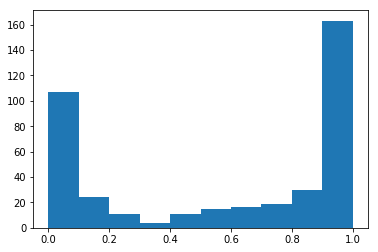

In [28]:
plt.hist(predictions0)

(array([112.,  25.,  12.,  11.,  11.,  13.,   8.,  21.,  32., 155.]),
 array([1.51838722e-05, 1.00001184e-01, 1.99987185e-01, 2.99973185e-01,
        3.99959185e-01, 4.99945186e-01, 5.99931186e-01, 6.99917187e-01,
        7.99903187e-01, 8.99889187e-01, 9.99875188e-01]),
 <a list of 10 Patch objects>)

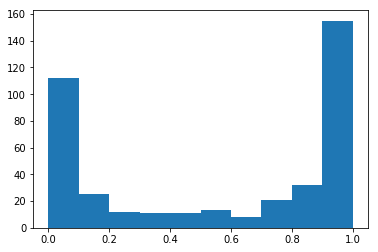

In [29]:
plt.hist(predictions1)

(array([130.,  19.,  12.,  12.,  11.,  10.,  13.,  24.,  23., 146.]),
 array([1.88105929e-07, 9.99930287e-02, 1.99985869e-01, 2.99978710e-01,
        3.99971550e-01, 4.99964391e-01, 5.99957231e-01, 6.99950072e-01,
        7.99942913e-01, 8.99935753e-01, 9.99928594e-01]),
 <a list of 10 Patch objects>)

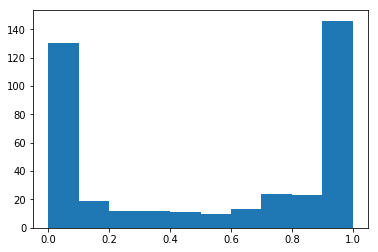

In [30]:
plt.hist(predictions2)

(array([113.,  15.,  12.,  20.,  14.,  12.,   9.,  14.,  31., 160.]),
 array([1.10341243e-05, 9.99993211e-02, 1.99987608e-01, 2.99975895e-01,
        3.99964182e-01, 4.99952469e-01, 5.99940756e-01, 6.99929043e-01,
        7.99917330e-01, 8.99905617e-01, 9.99893904e-01]),
 <a list of 10 Patch objects>)

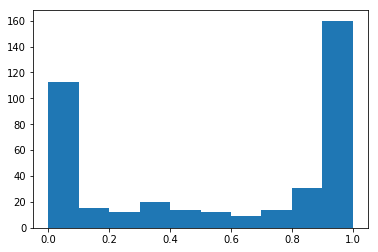

In [31]:
plt.hist(predictions3)

(array([125.,  12.,   7.,  13.,   9.,  12.,   9.,  20.,  43., 150.]),
 array([3.72740833e-05, 1.00026728e-01, 2.00016182e-01, 3.00005636e-01,
        3.99995089e-01, 4.99984543e-01, 5.99973997e-01, 6.99963451e-01,
        7.99952905e-01, 8.99942358e-01, 9.99931812e-01]),
 <a list of 10 Patch objects>)

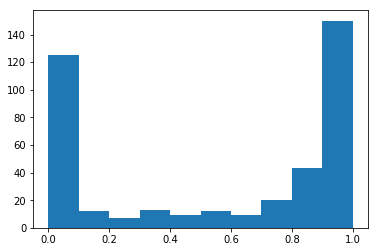

In [32]:
plt.hist(predictions4)

In [33]:
predictions = np.mean((predictions0, predictions1, predictions2, predictions3, predictions4), axis=0)

(array([115.,  16.,  12.,  12.,  15.,  15.,  13.,  14.,  42., 146.]),
 array([7.09194342e-05, 1.00045785e-01, 2.00020651e-01, 2.99995517e-01,
        3.99970382e-01, 4.99945248e-01, 5.99920114e-01, 6.99894980e-01,
        7.99869845e-01, 8.99844711e-01, 9.99819577e-01]),
 <a list of 10 Patch objects>)

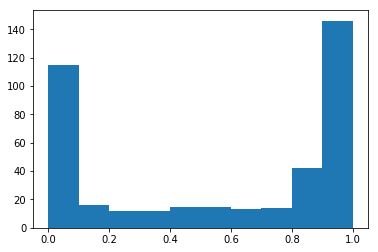

In [34]:
plt.hist(predictions)

In [35]:
submission_df = pd.DataFrame({"filename": test_videos, "label": predictions})

# post-processing
clip (0.1, 0.9) <br>
change 0.5 to 0.481

In [36]:
# clip
submission_df['label'] = submission_df['label'].clip(0.1, 0.9)

(array([130.,   8.,  12.,   5.,  15.,  10.,  15.,   8.,  19., 178.]),
 array([0.1 , 0.18, 0.26, 0.34, 0.42, 0.5 , 0.58, 0.66, 0.74, 0.82, 0.9 ]),
 <a list of 10 Patch objects>)

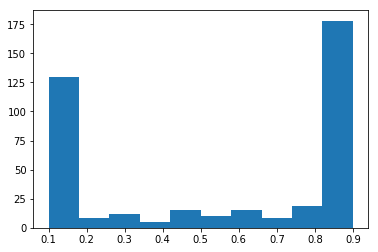

In [37]:
# check clip
plt.hist(submission_df['label'])

In [38]:
# change 0.5 to 0.481
submission_df = submission_df.replace(0.5, 0.481)

In [39]:
# save the file
submission_df.to_csv("submission.csv", index=False)

In [40]:
# check submission
df = pd.read_csv('submission.csv')
df.head()

,filename,label
0,aassnaulhq.mp4,0.9
1,aayfryxljh.mp4,0.1
2,acazlolrpz.mp4,0.9
3,adohdulfwb.mp4,0.1
4,ahjnxtiamx.mp4,0.9


(array([130.,   8.,  12.,   5.,  17.,   8.,  15.,   8.,  19., 178.]),
 array([0.1 , 0.18, 0.26, 0.34, 0.42, 0.5 , 0.58, 0.66, 0.74, 0.82, 0.9 ]),
 <a list of 10 Patch objects>)

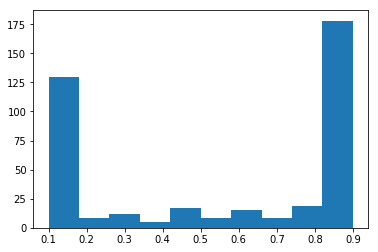

In [41]:
plt.hist(df['label'])

In [47]:
# save the seperate prediction files too
submission_df0 = pd.DataFrame({"filename": test_videos, "label": predictions0})
submission_df0['label'] = submission_df0['label'].clip(0.1, 0.9)
submission_df0 = submission_df0.replace(0.5, 0.481)
submission_df0.to_csv("submission_0.csv", index=False)

In [50]:
# save the seperate prediction files too
submission_df1 = pd.DataFrame({"filename": test_videos, "label": predictions1})
submission_df1['label'] = submission_df1['label'].clip(0.1, 0.9).replace(0.5, 0.481)
submission_df1.to_csv("submission_1.csv", index=False)

In [49]:
# save the seperate prediction files too
submission_df2 = pd.DataFrame({"filename": test_videos, "label": predictions2})
submission_df2['label'] = submission_df2['label'].clip(0.1, 0.9).replace(0.5, 0.481)
submission_df2.to_csv("submission_2.csv", index=False)

In [53]:
# save the seperate prediction files too
submission_df3 = pd.DataFrame({"filename": test_videos, "label": predictions3})
submission_df3['label'] = submission_df3['label'].clip(0.1, 0.9).replace(0.5, 0.481)
submission_df3.to_csv("submission_3.csv", index=False)

In [54]:
# save the seperate prediction files too
submission_df4 = pd.DataFrame({"filename": test_videos, "label": predictions4})
submission_df4['label'] = submission_df0['label'].clip(0.1, 0.9).replace(0.5, 0.481)
submission_df4.to_csv("submission_4.csv", index=False)

In [55]:
!ls

__notebook_source__.ipynb  submission_0.csv  submission_2.csv  submission_4.csv
submission.csv		   submission_1.csv  submission_3.csv


In [56]:
from IPython.display import FileLink
FileLink('submission.csv')

/kaggle/working/submission.csv

In [57]:
from IPython.display import FileLink
FileLink('submission_0.csv')

/kaggle/working/submission_0.csv

In [58]:
from IPython.display import FileLink
FileLink('submission_1.csv')

/kaggle/working/submission_1.csv

In [59]:
from IPython.display import FileLink
FileLink('submission_2.csv')

/kaggle/working/submission_2.csv

In [60]:
from IPython.display import FileLink
FileLink('submission_3.csv')

/kaggle/working/submission_3.csv

In [61]:
from IPython.display import FileLink
FileLink('submission_4.csv')

/kaggle/working/submission_4.csv